# Loan Default Prediction

## Using Logistic Regression and Random Forest

importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (
    roc_curve,
    auc,
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    precision_score,
    recall_score
)

Increasing the column width for better viewing

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

Loading the dataset

In [3]:
df = pd.read_csv("Loan_default.csv")

Getting some information about the dataset

In [4]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


Removing columns that are not needed

In [5]:
df = df.drop("LoanID", axis=1)

In [6]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [7]:
print(df.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  object 
 10  EmploymentType  255347 non-null  object 
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes: float64

Identifying the number of missing values in the dataset

In [8]:
print(df.isnull().sum())

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


Getting the number of duplicated values

In [9]:
print(df.duplicated().sum())

0


Making the feature variable and the target variable

In [10]:
X = df.drop("Default", axis=1)
y = df["Default"]

In [11]:
print(X.head())

   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose HasCoSigner
0   56   85994       50587          520              80               4         15.23        36      0.44   Bachelor's      Full-time      Divorced         Yes           Yes       Other         Yes
1   69   50432      124440          458              15               1          4.81        60      0.68     Master's      Full-time       Married          No            No       Other         Yes
2   46   84208      129188          451              26               3         21.17        24      0.31     Master's     Unemployed      Divorced         Yes           Yes        Auto          No
3   32   31713       44799          743               0               3          7.07        24      0.23  High School      Full-time       Married          No            No    Business          No
4   60   2

In [12]:
print(y.head())

0    0
1    0
2    1
3    0
4    0
Name: Default, dtype: int64


Preparing the categorical columns for encoding into numerical values 

In [13]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
print(numerical_cols)

one_hot_cols = ["Education", "EmploymentType", "MaritalStatus", "LoanPurpose"]

label_encode_cols = ["HasMortgage", "HasDependents", "HasCoSigner"]

['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']


In [14]:
def label_encode_transformer(X):
    X_encoded = X.copy()
    for columns in X.columns:
        le = LabelEncoder()
        X_encoded[columns] = le.fit_transform(X_encoded[columns])
    return X_encoded

Applying different preprocessing steps for different encoding columns

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
        ('label', OrdinalEncoder(), label_encode_cols)
    ],
    remainder='passthrough'
)

Splitting the dataset for training and testing purpose

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Getting all the models for training the dataset

In [17]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest Classifier": RandomForestClassifier(random_state=42, class_weight='balanced')
}

Training the model

Finding the predicted values and probability values 

Evaluating the models

Making the visualization: Confusion Matrix and ROC Curve


Model: Logistic Regression
Accuracy: 0.6764
Precision: 0.2196
Recall: 0.6992
F1-Score: 0.3342


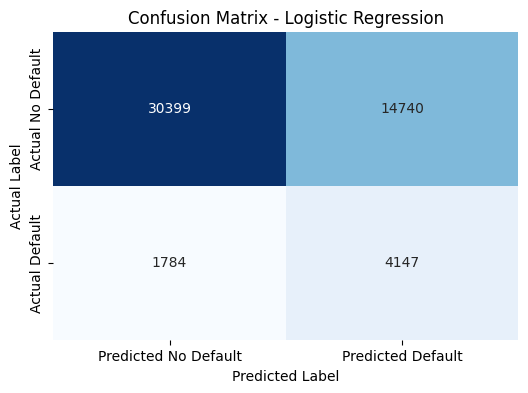

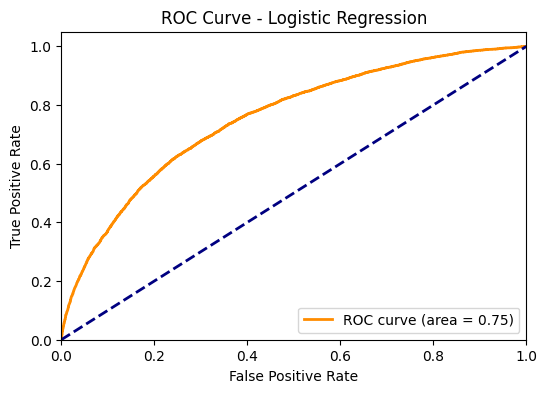


Model: Decision Tree Classifier
Accuracy: 0.8171
Precision: 0.2052
Recall: 0.2000
F1-Score: 0.2025


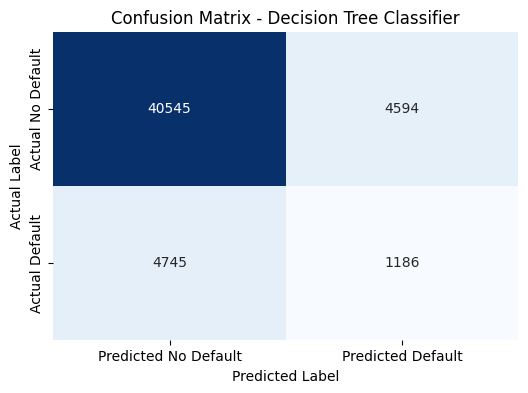

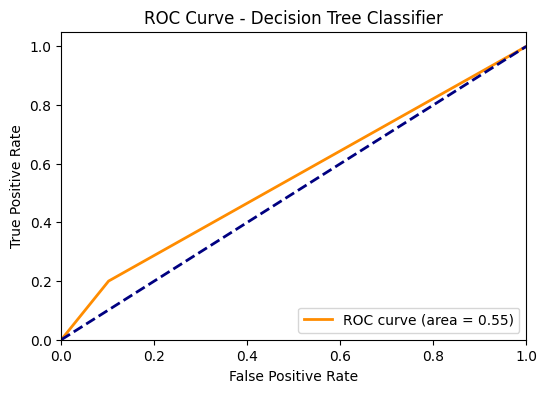


Model: Random Forest Classifier
Accuracy: 0.8847
Precision: 0.6414
Recall: 0.0157
F1-Score: 0.0306


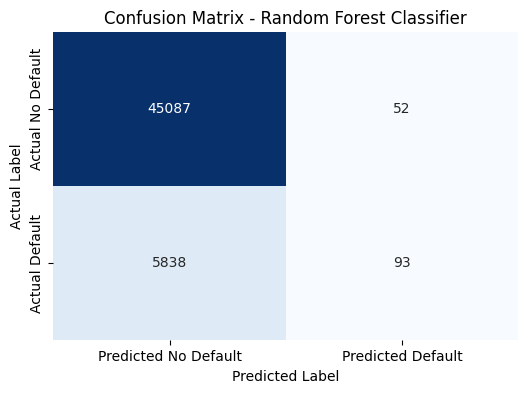

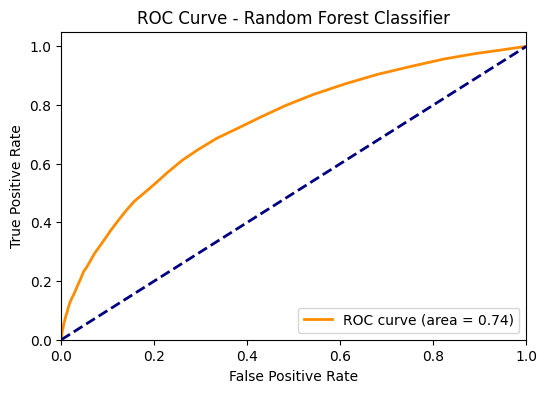

In [19]:
for name, classifier in models.items():
    print(f"\nModel: {name}")

    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', classifier)])

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1] 

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Default', 'Predicted Default'],
                yticklabels=['Actual No Default', 'Actual Default'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'Confusion Matrix - {name}.png')
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.savefig(f'ROC Curve - {name}.png')
    plt.show()